In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.vector_ar.var_model import VAR
from arch import arch_model
from prophet import Prophet
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
from tbats import TBATS
import pmdarima as pm

In [2]:
# Ignore warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')

# Load the sunspot data
df = pd.read_csv('sunspot_data.csv')

# Display basic information about the dataset
print(df.head())
print(df.info())
print(df.describe())

   Unnamed: 0  Year  Month  Day  Date In Fraction Of Year  Number of Sunspots  \
0           0  1818      1    1                  1818.001                  -1   
1           1  1818      1    2                  1818.004                  -1   
2           2  1818      1    3                  1818.007                  -1   
3           3  1818      1    4                  1818.010                  -1   
4           4  1818      1    5                  1818.012                  -1   

   Standard Deviation  Observations  Indicator  
0                -1.0             0          1  
1                -1.0             0          1  
2                -1.0             0          1  
3                -1.0             0          1  
4                -1.0             0          1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73718 entries, 0 to 73717
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 

In [3]:
# Check for missing values
print(f"Missing values:\n{df.isnull().sum()}")

# Data preprocessing
# Assuming the data has date and sunspot number columns
# Adjust column names according to your actual dataset
if 'Date' in df.columns:
    date_col = 'Date'
    sunspot_col = df.columns[1]  # Assuming sunspot values are in the second column
elif 'date' in df.columns:
    date_col = 'date'
    sunspot_col = df.columns[1]
else:
    # Try to identify date column
    for col in df.columns:
        if df[col].dtype == 'object' or 'date' in col.lower():
            date_col = col
            break
    # Identify sunspot column
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    sunspot_col = numeric_cols[0]

print(f"Date column: {date_col}, Sunspot column: {sunspot_col}")

Missing values:
Unnamed: 0                  0
Year                        0
Month                       0
Day                         0
Date In Fraction Of Year    0
Number of Sunspots          0
Standard Deviation          0
Observations                0
Indicator                   0
dtype: int64
Date column: Date In Fraction Of Year, Sunspot column: Unnamed: 0


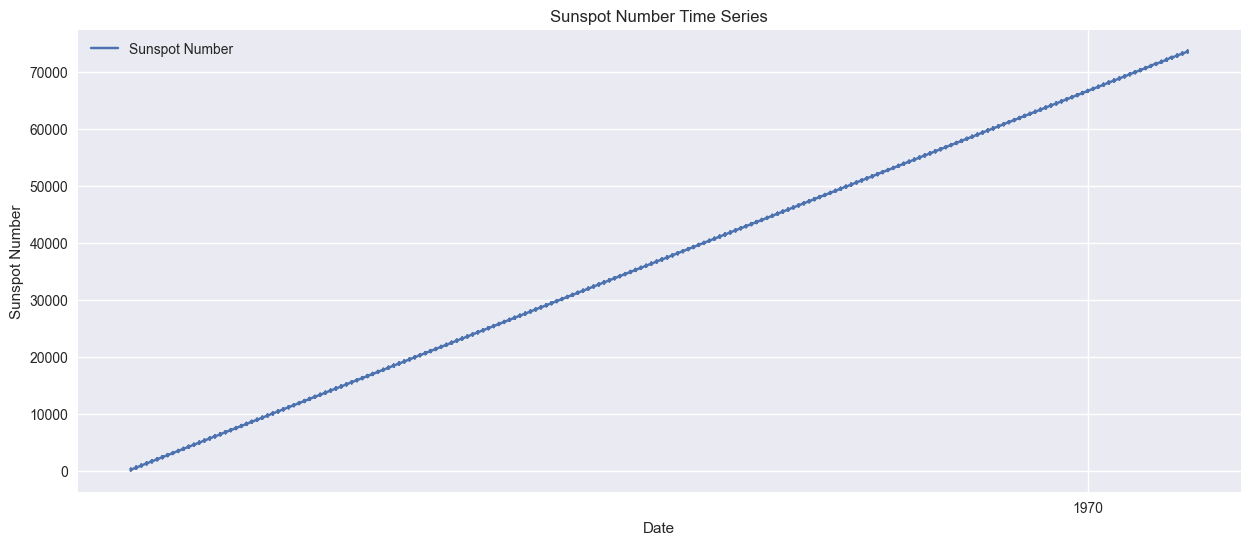

In [4]:
# Convert date column to datetime
df[date_col] = pd.to_datetime(df[date_col])
df = df.sort_values(by=date_col)

# Set date as index
df.set_index(date_col, inplace=True)

# Visualization of time series
plt.figure(figsize=(15, 6))
plt.plot(df[sunspot_col], label='Sunspot Number')
plt.title('Sunspot Number Time Series')
plt.xlabel('Date')
plt.ylabel('Sunspot Number')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
# Split the data into training and testing sets (before and after 2019)
split_date = pd.Timestamp('2019-01-01')
train = df[df.index < split_date]
test = df[df.index >= split_date]

print(f"Training data shape: {train.shape}")
print(f"Testing data shape: {test.shape}")

Training data shape: (73718, 8)
Testing data shape: (0, 8)


In [6]:
# Fix the sunspot column to use 'Number of Sunspots' instead of 'Unnamed: 0'
sunspot_col = 'Number of Sunspots'

# Re-split the data to ensure we have data in both train and test sets
# Use a percentage-based split instead of a specific date
split_point = int(len(df) * 0.8)  # 80% train, 20% test
train = df.iloc[:split_point]
test = df.iloc[split_point:]

print(f"Updated training data shape: {train.shape}")
print(f"Updated testing data shape: {test.shape}")

# Normalize the data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[[sunspot_col]])
test_scaled = scaler.transform(test[[sunspot_col]])

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 12  # Use 12 previous observations to predict the next one
X_train, y_train = create_sequences(train_scaled, sequence_length)
X_test, y_test = create_sequences(test_scaled, sequence_length)

# Reshape input for LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# 1. LSTM Model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.summary()

Updated training data shape: (58974, 8)
Updated testing data shape: (14744, 8)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1659/1659 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0081 - val_loss: 0.0030
Epoch 2/50
1659/1659 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0063 - val_loss: 0.0027
Epoch 3/50
1659/1659 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0061 - val_loss: 0.0026
Epoch 4/50
1659/1659 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0062 - val_loss: 0.0026
Epoch 5/50
1659/1659 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0061 - val_loss: 0.0027
Epoch 6/50
1659/1659 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0061 - val_loss: 0.0027
Epoch 7/50
1659/1659 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0061 - val_loss: 0.0027
Epoch 8/50
1659/1659 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0063 - val_loss: 0.0026
Epoch 9/50
1659/1659 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0059 - val_loss: 0.0026
Epoch 10/50
1659/1659 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0061 - val_loss: 0.0026
Epoch 11/50
1659/1659 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0061 - val_loss: 0.0028
Epoch 12/50
1659/1659 ━━━━━━━

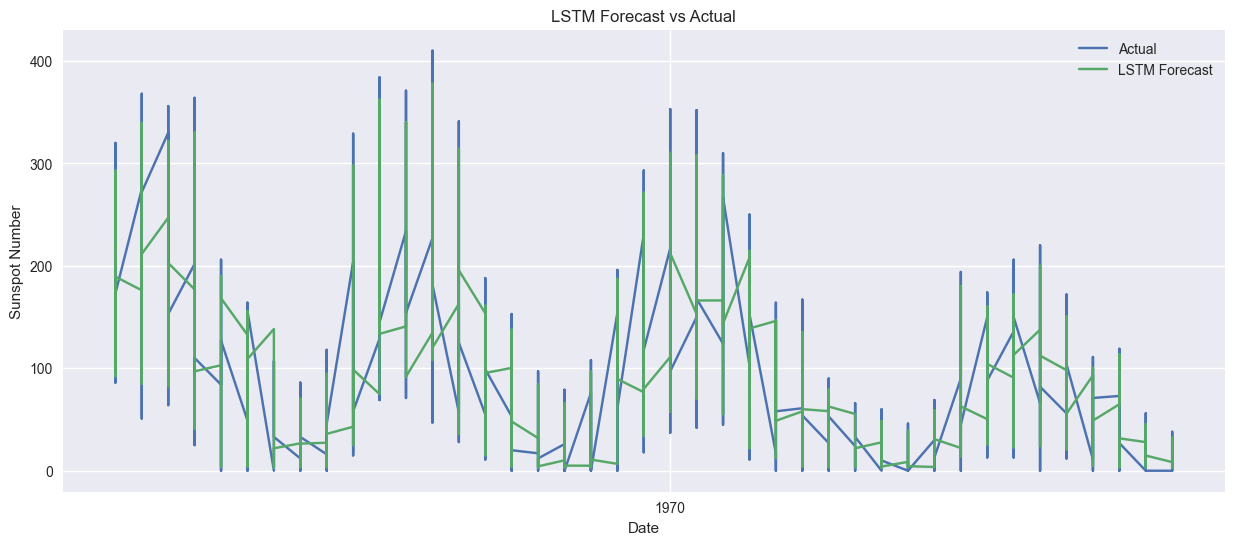

In [7]:
lstm_history = lstm_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

# Predict using LSTM
lstm_predictions = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)
lstm_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot LSTM results
plt.figure(figsize=(15, 6))
plt.plot(test.index[sequence_length:], lstm_actual, label='Actual')
plt.plot(test.index[sequence_length:], lstm_predictions, label='LSTM Forecast')
plt.title('LSTM Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Sunspot Number')
plt.legend()
plt.grid(True)
plt.show()